In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
# Define the sigma function
def sigma(altitude):
    a = 1
    b = 0.05
    return a * (1 - np.exp(-b * altitude))


# Simulate the sensor model to create an observation matrix z
def sensor_model(true_matrix, altitude):
    sig = sigma(altitude)
    P_z_equals_m = 1 - sig
    P_z_not_equals_m = sig

    rows, cols = true_matrix.shape
    observation_matrix = np.zeros((rows, cols))

    for i in range(rows):
        for j in range(cols):
            if true_matrix[i, j] == 1:
                observation_matrix[i, j] = np.random.choice([1, 0], p=[P_z_equals_m, P_z_not_equals_m])
            else:
                observation_matrix[i, j] = np.random.choice([0, 1], p=[P_z_equals_m, P_z_not_equals_m])

    return observation_matrix

# Calculate true positive, false negative, etc.
def calculate_statistics_(true_matrix, observation):
    true_positive = np.sum((true_matrix == 1) & (observation ==1))
    false_negative = np.sum((true_matrix == 1) & (observation ==0))
    false_positive = np.sum((true_matrix == 0) & (observation == 1))
    true_negative = np.sum((true_matrix == 0) & (observation ==  0))
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # accuracy = (true_positive + true_negative) / true_matrix.size
    
    return {
        'True Positive': true_positive,
        'False Negative': false_negative,
        'False Positive': false_positive,
        'True Negative': true_negative,
        'F1 Score': f1_score,
        # 'Accuracy': accuracy
        }

In [2]:
# Sample the sensor model N times and geenrate observation matrix
def sampler(true_matrix, altitude, N):
    cumulative_observation = np.empty((0,2))
    # cumulative_observation = np.zeros((N, rows, cols), dtype=int)
    for i in range(N):
        observation_matrix = sensor_model(true_matrix, altitude)
        cumulative_observation = np.vstack([cumulative_observation, observation_matrix])
    return cumulative_observation

In [12]:
N_max = 500
hs = [ 5.41, 10.83, 16.24, 21.65, 27.06, 32.48]

N_values = list(range(1, N_max+1, 5))

true_matrix = np.array([0,1])
true_matrix = np.expand_dims(true_matrix, axis=0)
N_values = N_values[0:int(len(N_values)/2)]
N0 = N_max/2
N1 = N_max/2

In [13]:
alt_dict = {}
all_data = {}
# N_max = 3
# N_values = list(range(1, N_max+1, 1))
for i, altitude in enumerate(hs):
    alt_dict={}
    for N in N_values:
        observation = sampler(true_matrix, altitude, N)
        stats = calculate_statistics_(true_matrix, observation)
        alt_dict[2*N]={
            "S":    round(sigma(altitude), 2),
            "FP":   round(stats["False Positive"]/N,  2),
            "FN":   round(stats["False Negative"]/N,  2),
            "TN":   round(stats["True Negative"]/N,   2),
            "TP":   round(stats["True Positive"]/N,   2),
            "1-S":  round(1-sigma(altitude), 2),
            }
        # print(f'obs: {observation}')
        # print(f"stat {stats}")

    all_data[altitude] = alt_dict
    # break
        

In [14]:
metrics = ["FP", "FN", "TN", "TP"]
variability = {metric: [] for metric in metrics}
print(all_data.keys())
for alt in hs:
    samples = all_data[alt]
    sample_numbers = sorted(samples.keys()) 
    # print(samples)
    # break
    # for 
    for metric in metrics:
        values = [samples[n][metric] for n in sample_numbers]
        std_dev = np.std(values)
        variability[metric].append(std_dev)
    #     print(f"alt {alt}, metric {metric}, valuies {values}")
    #     print(f"std dev {std_dev}")
    #     print(f"var : {variability[metric]}")
    #     # break
    # break
print(variability)

dict_keys([5.41, 10.83, 16.24, 21.65, 27.06, 32.48])
{'FP': [0.059114803560529575, 0.07975061128292373, 0.0887567462224703, 0.0742008086209308, 0.07002399588712428, 0.05356454050955725], 'FN': [0.056064605590336575, 0.10405767631462853, 0.09651942809610922, 0.11206944275760454, 0.057327480321395605, 0.06491871841002408], 'TN': [0.05911480356052959, 0.07975061128292371, 0.08875674622247032, 0.0742008086209308, 0.0700239958871243, 0.05356454050955725], 'TP': [0.05606460559033658, 0.1040576763146285, 0.09651942809610922, 0.11206944275760455, 0.0573274803213956, 0.06491871841002407]}


In [30]:
altitudes

[5.41, 10.83, 16.24, 21.65, 27.06, 32.48]

In [29]:
def calc_n(h):
    e = np.array([0.5,0.4,0.3,0.2,0.1,0.05,0.03,0.02,0.01])
    p = sigma(h)
    p_ = 1 - p 
    return 1.96*1.96*p*p_/e

altitudes = [5.41, 10.83, 16.24, 21.65, 27.06, 32.48]
for h in altitudes:
    n = calc_n(h)

[ 1.38936923  1.73671153  2.31561538  3.47342307  6.94684613 13.89369226
 23.15615377 34.73423065 69.4684613 ]
[ 1.86929582  2.33661977  3.11549303  4.67323955  9.34647909 18.69295819
 31.15493032 46.73239547 93.46479095]
[ 1.89667901  2.37084876  3.16113168  4.74169752  9.48339504 18.96679007
 31.61131679 47.41697518 94.83395037]
[ 1.72101884  2.15127355  2.86836474  4.3025471   8.60509421 17.21018841
 28.68364735 43.02547103 86.05094206]
[ 1.47256379  1.84070474  2.45427298  3.68140947  7.36281895 14.72563789
 24.54272982 36.81409474 73.62818947]
[ 1.21591904  1.5198988   2.02653174  3.0397976   6.07959521 12.15919042
 20.26531736 30.39797604 60.79595208]


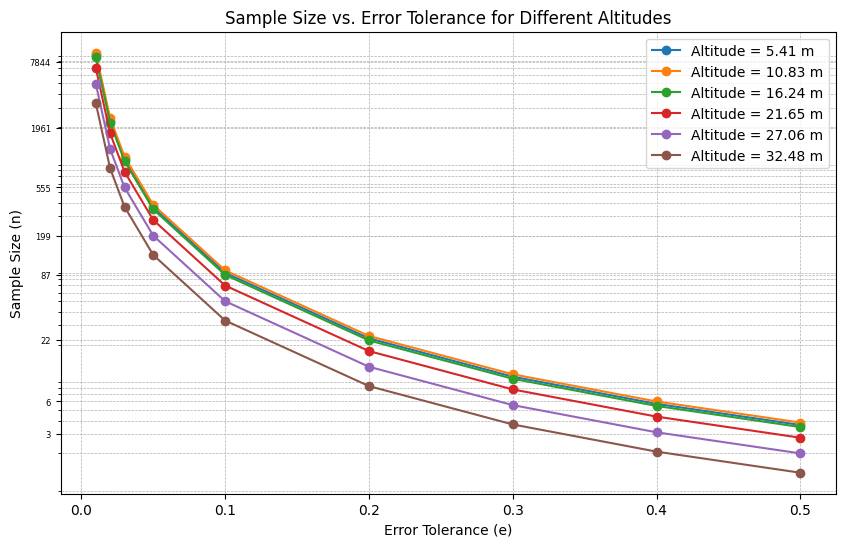

In [90]:
# Function to calculate n
def calc_n(h):
    e = np.array([0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.03, 0.02, 0.01])
    p = sigma(h)
    p_ = 1 - p
    return 1.96 * 1.96 * p * p_ / e/e

# Altitudes
altitudes = [5.41, 10.83, 16.24, 21.65, 27.06, 32.48]
errors = np.array([0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.03, 0.02, 0.01])

# Plotting
plt.figure(figsize=(10, 6))

# Collect n-values for y-ticks
all_n_values = []
for h in altitudes:
    n_values = calc_n(h)
    all_n_values.extend(n_values)
    plt.plot(errors, n_values, marker='o', label=f'Altitude = {h} m')

# Select specific n-values for y-ticks
unique_n_values = group_and_select_representative(all_n_values, num_groups=8)
plt.yscale('log')  # Ensure logarithmic scale
plt.yticks(ticks=unique_n_values, labels=[f"{val}" for val in unique_n_values], fontsize=6)  # Apply ticks

# Add labels and legend
plt.xlabel('Error Tolerance (e)')
plt.ylabel('Sample Size (n)')
plt.title('Sample Size vs. Error Tolerance for Different Altitudes')
# plt.xscale('log')  # Log scale for error tolerance
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()

In [89]:
import numpy as np

def group_and_select_representative(numbers, num_groups=5, tight_threshold=0.5):
    # Sort the numbers in ascending order
    sorted_numbers = sorted(numbers)
    
    # Determine the range of values
    min_val, max_val = min(sorted_numbers), max(sorted_numbers)
    
    # Calculate bin edges (ranges) on log scale
    log_min = np.log10(min_val)
    log_max = np.log10(max_val)
    bin_edges = np.logspace(log_min, log_max, num_groups + 1)
    
    # Group the numbers into bins
    grouped = []
    for i in range(num_groups):
        group = [num for num in sorted_numbers if bin_edges[i] <= num < bin_edges[i + 1]]
        if group:
            grouped.append(group)
    
    # Select the most representative number from each group
    representative_numbers = []
    for group in grouped:
        group_min = int(min(group))
        group_max = int(max(group))
        
        # Determine if the bin is tight or distant based on the logarithmic scale
        log_range = np.log10(group_max) - np.log10(group_min)
        if log_range > tight_threshold:  # Distant bin, use min and max
            representative_numbers.append((group_min, group_max))
        else:  # Tight bin, use median
            representative_numbers.append(int(np.median(group)))
    
    return representative_numbers

# Example usage
numbers = [1, 2, 3, 6, 7, 8, 15, 16, 18, 22, 25, 30, 32, 35, 40, 50, 100, 200, 500, 1000, 1400, 1200]
representative_numbers = group_and_select_representative(numbers, num_groups=4, tight_threshold=0.5)
print("Representative numbers:", representative_numbers)


Representative numbers: [(1, 6), (7, 35), (40, 200), 1100]


In [80]:
import numpy as np

def group_and_select_representative(numbers, num_groups=5):
    # Sort the numbers in ascending order
    sorted_numbers = sorted(numbers)
    
    # Determine the range of values
    min_val, max_val = min(sorted_numbers), max(sorted_numbers)
    
    # Calculate bin edges (ranges)
    bin_edges = np.linspace(min_val, max_val, num_groups + 1)
    
    # Group the numbers into bins
    grouped = []
    for i in range(num_groups):
        group = [num for num in sorted_numbers if bin_edges[i] <= num < bin_edges[i + 1]]
        if group:
            grouped.append(group)
    
    # Select the most representative number from each group (e.g., median of the group)
    representative_numbers = [int(np.median(group)) for group in grouped]
    
    return representative_numbers

# Example usage
numbers =   all_n_values
representative_numbers = group_and_select_representative(numbers, num_groups=10)
print("Representative numbers:", representative_numbers)


Representative numbers: [14, 1065, 2278, 3319, 4996, 6962, 8920]


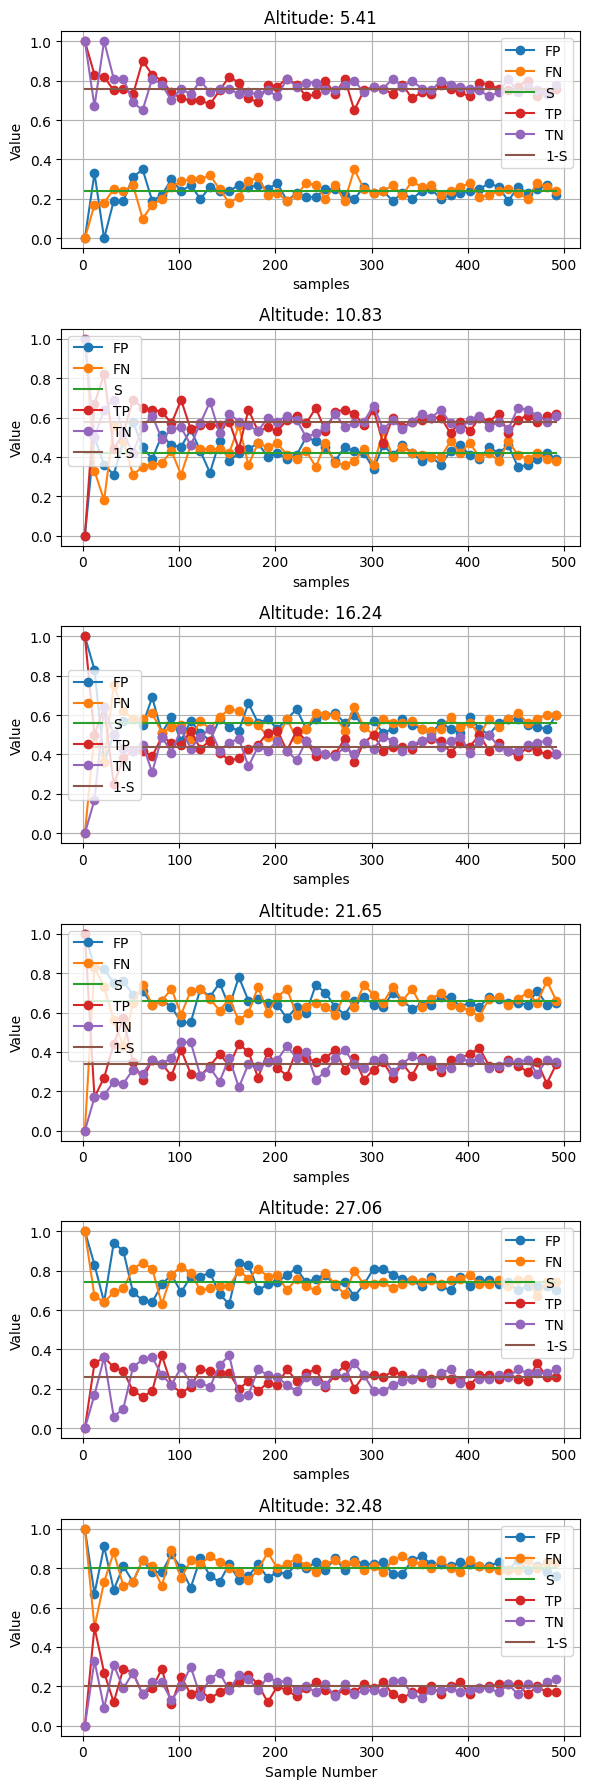

In [15]:

# Prepare data for plotting
altitudes = list(all_data.keys())

# Create subplots for each altitude
fig, axes = plt.subplots(len(altitudes), 1, figsize=(6, 3 * len(altitudes)), sharex=False)

# Plot for each altitude
for idx, altitude in enumerate(altitudes):
    samples = all_data[altitude]
    sample_numbers = sorted(samples.keys())
    
    # Extract values for FP, FN, S, TP, TN, and 1-S
    FP  = [samples[n]['FP'] for n in sample_numbers]
    FN  = [samples[n]['FN'] for n in sample_numbers]
    S   = [samples[n]['S']  for n in sample_numbers]
    TP  = [samples[n]['TP'] for n in sample_numbers]
    TN  = [samples[n]['TN'] for n in sample_numbers]
    one_minus_S = [samples[n]['1-S'] for n in sample_numbers]
    
    # Plot FP, FN, S, TN, TP, and 1-S
    ax = axes[idx]
    ax.plot(sample_numbers, FP, label='FP', marker='o')
    ax.plot(sample_numbers, FN, label='FN', marker='o')
    ax.plot(sample_numbers, S,  label='S',) # marker='o')
    ax.plot(sample_numbers, TP, label='TP', marker='o')
    ax.plot(sample_numbers, TN, label='TN', marker='o')
    ax.plot(sample_numbers, one_minus_S, label='1-S',) #marker='o')
    
    ax.set_title(f'Altitude: {altitude}')
    ax.set_ylabel('Value')
    ax.set_xlabel('samples')
    ax.grid(True)
    ax.legend(loc='best')

# Set common x-label
plt.xlabel('Sample Number')
plt.tight_layout()
plt.show()
